In [5]:
from IPython.display import clear_output 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
import sys
import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
import glob
from utils import imshow, get_feature_extractor
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std, transforms
from PapilledemaLoader import PapilledemaDataset

## Binary and Multiclass severity Classification

In [12]:
computername = 'Hong'

data_dir = f'/mnt/c/Users/{computername}/Dropbox/chla_fundus_croped/binary_classes'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['papilledema', 'pseudopapilledema']


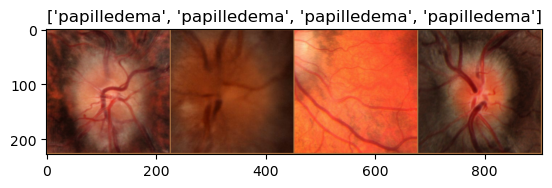

In [26]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [27]:
siamese50simclr = get_feature_extractor(feature_extractor='resnet101', cotrain=False)#, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
siamese50simclr.fc = nn.Sequential(torch.nn.Linear(2048, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 2))

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/hongn/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


KeyboardInterrupt: 

In [37]:
# from torch.optim import lr_scheduler
siamese50simclr = siamese50simclr.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': siamese50simclr.fc.parameters()}], lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

In [38]:
# bestmodel = siamese50simclr
valaccmax = 0
for e in range(50):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    for inputs, labels in dataloaders['train']:
        siamese50simclr.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = siamese50simclr(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)

    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = siamese50simclr(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)

        if(val_acc > valaccmax):
            valaccmax = val_acc
            torch.save(siamese50simclr.state_dict(), './SimCLR/pretrained/best-siamese50-wosimclr.pt')

    scheduler.step()

    print(f"EPOCH {e} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

EPOCH 0 training acc:  0.6512455516014235 Val acc:  0.16666666666666666 traning loss:  0.6475817213279073
EPOCH 1 training acc:  0.693950177935943 Val acc:  0.44166666666666665 traning loss:  0.61334078454038
EPOCH 2 training acc:  0.6779359430604982 Val acc:  0.55 traning loss:  0.6088852627845845
EPOCH 3 training acc:  0.6868327402135231 Val acc:  0.4083333333333333 traning loss:  0.5975739947417452
EPOCH 4 training acc:  0.6761565836298933 Val acc:  0.15833333333333333 traning loss:  0.6051337965018384
EPOCH 5 training acc:  0.697508896797153 Val acc:  0.26666666666666666 traning loss:  0.5792276450959813
EPOCH 6 training acc:  0.7117437722419929 Val acc:  0.38333333333333336 traning loss:  0.5865015575257909
EPOCH 7 training acc:  0.7135231316725978 Val acc:  0.375 traning loss:  0.5750691010434432
EPOCH 8 training acc:  0.7170818505338078 Val acc:  0.2 traning loss:  0.589868505654386
EPOCH 9 training acc:  0.701067615658363 Val acc:  0.3333333333333333 traning loss:  0.5722676403

### Testing and Evaluation

In [83]:
bestmodel = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 2))
bestmodel.load_state_dict(torch.load('./SimCLR/pretrained/best-siamese101simclr.pt'))
bestmodel.to(device)


load simclr resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
test_acc = 0
predlist = []
labelist = []
problist = []

for inputs, labels in dataloaders['test']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)

    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())

    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()

In [85]:
print("test_acc acc: ", test_acc / dataset_sizes['test'])

test_acc acc:  tensor(0.6708, device='cuda:0')


In [86]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.931     0.346     0.505        78
           1      0.614     0.976     0.753        83

    accuracy                          0.671       161
   macro avg      0.772     0.661     0.629       161
weighted avg      0.767     0.671     0.633       161



0.8015137472968799

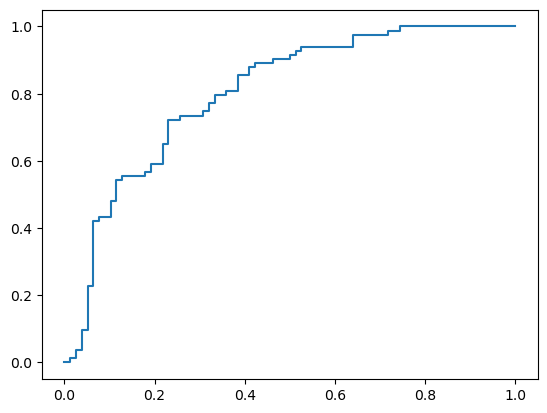

In [87]:
import sklearn.metrics as metrics

y_test = (labelist)
y_pred =(problist)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
roc_auc_score(y_test, y_pred)

In [67]:
# siamese50simclr = RankNet_wresnet(feature_extractor='resnet101', cotrain=False).fextractor
for param in bestmodel.parameters():
    param.requires_grad = True

In [68]:
X, y = next(iter(dataloaders['test']))
print('True label : ', y, ' and predicted: ', torch.max(siamese50simclr(X.cuda()),1)[1])

True label :  tensor([1, 0, 1, 1])  and predicted:  tensor([0, 1, 1, 1], device='cuda:0')


True label :  tensor([1, 0, 0, 0])  and predicted:  tensor([1, 0, 1, 0], device='cuda:0')


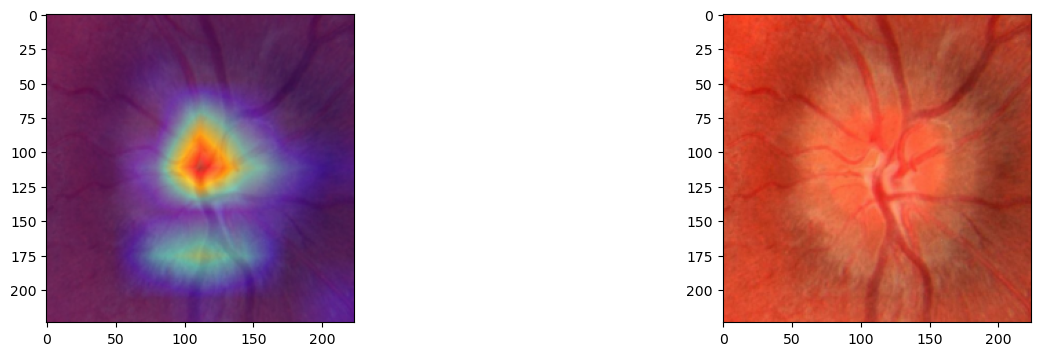

In [71]:
from pytorch_grad_cam.utils.image import show_cam_on_image

model = bestmodel.eval()
target_layers = [model.layer4[-1]]

X, y = next(iter(dataloaders['test']))
print('True label : ', y, ' and predicted: ', torch.max(siamese50simclr(X.cuda()),1)[1])
input_tensorA = X[0].unsqueeze(0)
rgb_imgA = imgtensor2array(X[0], mean=mean, std=std)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_camA = cam(input_tensor=input_tensorA)

visualizationA = show_cam_on_image(rgb_imgA, grayscale_camA[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(visualizationA, label= 'heatmap A')
ax[1].imshow(rgb_imgA, label= 'heatmap A')


## Severity Comparison using contrastive loss Learning